<a href="https://colab.research.google.com/github/Satyexe/RetroColor/blob/main/RetroColor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the transformation to load RGB images (we'll convert them to grayscale later)
transform = transforms.ToTensor()

# Load CIFAR-10 test dataset
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


100%|██████████| 170M/170M [00:03<00:00, 43.9MB/s]


In [2]:
from google.colab import files
uploaded = files.upload()


Saving camera.jpg to camera.jpg


In [34]:
from PIL import Image

# Open the uploaded image — replace with your uploaded filename if different
img = Image.open("camera.jpg")

# Convert to grayscale
gray_img = img.convert("L")


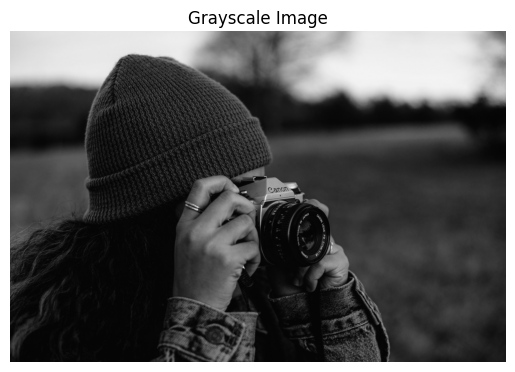

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Convert grayscale image to numpy array
gray_np = np.array(gray_img)

# Display using matplotlib
plt.imshow(gray_np, cmap='gray')
plt.title("Grayscale Image")
plt.axis("off")
plt.show()


In [36]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


In [37]:
class ColorizationAutoencoder(nn.Module):
    def __init__(self):
        super(ColorizationAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Sigmoid()  # Output in range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [38]:
# Resize image to 64X64 (to match CIFAR-10 input size used during training)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),  # Converts to [0, 1] tensor
])

gray_tensor = transform(gray_img).unsqueeze(0)  # Add batch dimension
print("Gray shape:", gray_tensor.shape)  # Should be [1, 1, 64, 64]


Gray shape: torch.Size([1, 1, 64, 64])


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ColorizationAutoencoder().to(device)
model.eval()


ColorizationAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)

In [40]:
import os
print(os.listdir('.'))


['.config', 'color_model.pth', 'horse_gre.jpg', 'horse_colorized.jpg', 'camera.jpg', 'data', 'sample_data']


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [42]:
class ColorizationAutoencoder(nn.Module):
    def __init__(self):
        super(ColorizationAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [43]:
transform_rgb = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_rgb)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)


In [44]:
def rgb_to_grayscale(batch):
    # Convert RGB [B, 3, H, W] to grayscale [B, 1, H, W]
    r, g, b = batch[:, 0:1, :, :], batch[:, 1:2, :, :], batch[:, 2:3, :, :]
    gray = 0.299 * r + 0.587 * g + 0.114 * b
    return gray


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ColorizationAutoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 10  # Train for a few epochs

for epoch in range(epochs):
    for batch in train_loader:
        rgb_images = batch[0].to(device)  # [B, 3, H, W]
        gray_images = rgb_to_grayscale(rgb_images).to(device)  # [B, 1, H, W]

        outputs = model(gray_images)
        loss = criterion(outputs, rgb_images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 1/10, Loss: 0.0055
Epoch 2/10, Loss: 0.0043
Epoch 3/10, Loss: 0.0086
Epoch 4/10, Loss: 0.0047
Epoch 5/10, Loss: 0.0046
Epoch 6/10, Loss: 0.0060
Epoch 7/10, Loss: 0.0042
Epoch 8/10, Loss: 0.0074
Epoch 9/10, Loss: 0.0058
Epoch 10/10, Loss: 0.0062


In [46]:
torch.save(model.state_dict(), "color_model.pth")


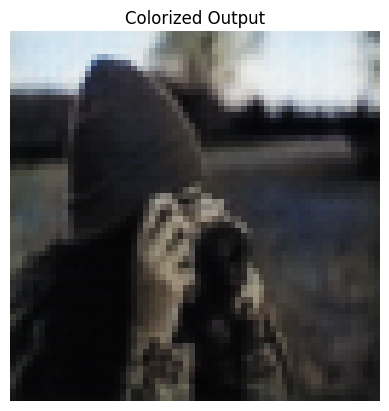

In [47]:
from PIL import Image

# Load grayscale image and resize to 64 X 64
gray_img = Image.open("camera.jpg").convert("L").resize((64, 64))
gray_tensor = transforms.ToTensor()(gray_img).unsqueeze(0).to(device)  # [1, 1, 64, 64]

# Load model if needed
model.load_state_dict(torch.load("color_model.pth", map_location=device))
model.eval()

# Colorize
with torch.no_grad():
    color_pred = model(gray_tensor)

# Display
color_np = color_pred.squeeze().cpu().permute(1, 2, 0).numpy()
plt.imshow(color_np)
plt.title("Colorized Output")
plt.axis("off")
plt.show()


In [48]:
import torchvision.transforms as transforms

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    # If you need to normalize, uncomment the following line
    # transforms.Normalize(mean=[0.5], std=[0.5])  # Assuming you want to normalize to [-1, 1] range
])



In [49]:
# Apply the transformations
img_tensor = transform(gray_img).unsqueeze(0)  # Add a batch dimension

# Ensure the model is in evaluation mode
model.eval()

# Move the image tensor to the device where your model is (likely 'cuda' if using GPU)
img_tensor = img_tensor.to(device)

# Get the model's output
with torch.no_grad():
    colorized_tensor = model(img_tensor)


In [50]:
# Convert the tensor back to an image
colorized_img = transforms.ToPILImage()(colorized_tensor.squeeze(0).cpu())

# Optionally, save the image
colorized_img.save("./horse_colorized.jpg")


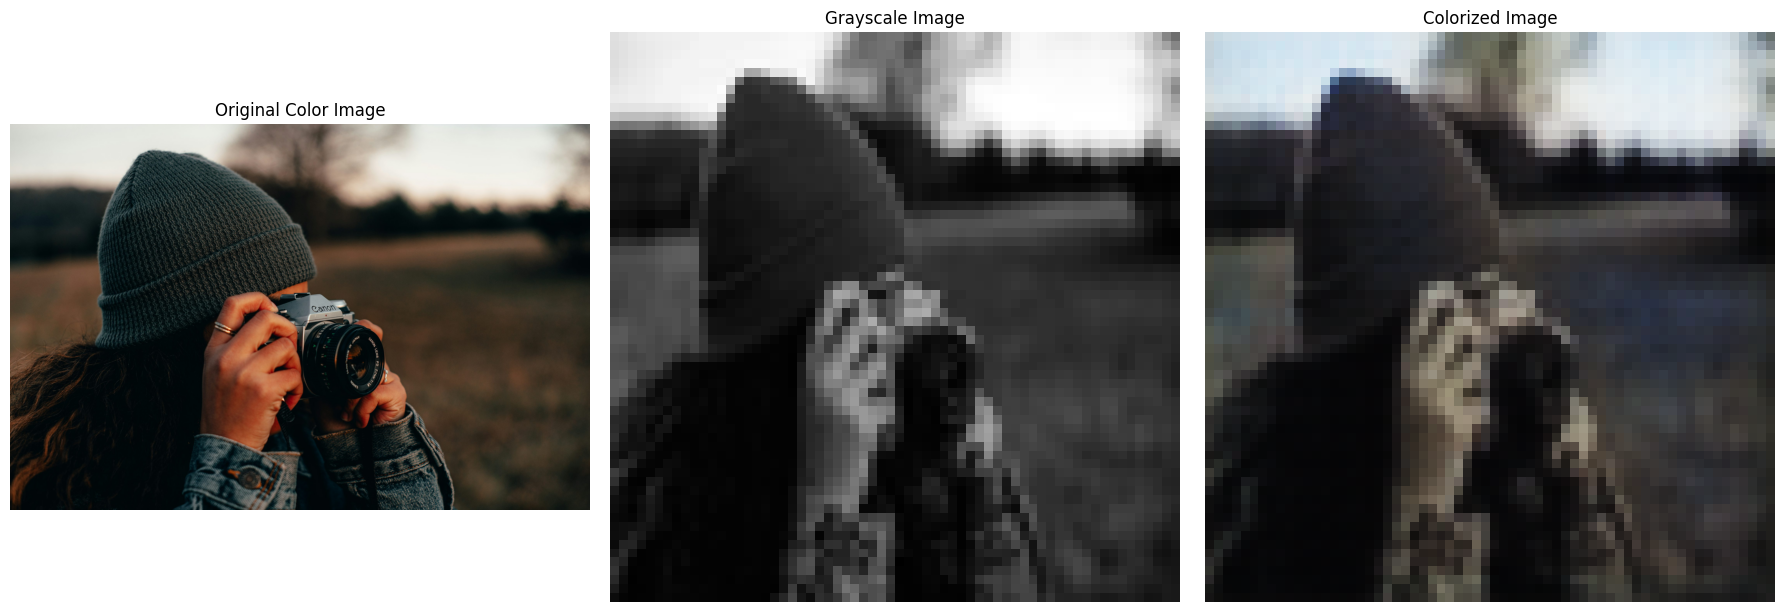

In [51]:
# Plotting the original, grayscale, and colorized images side-by-side
fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure with 1 row and 3 columns

# Display original color image
ax[0].imshow(img)
ax[0].set_title("Original Color Image")
ax[0].axis('off')  # Hide axes

# Display grayscale image
ax[1].imshow(gray_img, cmap='gray')  # Since it's grayscale, use cmap='gray'
ax[1].set_title("Grayscale Image")
ax[1].axis('off')  # Hide axes

# Display colorized image
ax[2].imshow(colorized_img)
ax[2].set_title("Colorized Image")
ax[2].axis('off')  # Hide axes

plt.tight_layout()  # Adjust spacing
plt.show()

In [53]:
gray_img.save("./image.jpg")